In [1]:
%matplotlib inline

In [2]:
from contextlib import closing
from datetime import datetime
from itertools import count, chain
from threading import Thread

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [3]:
def timestamp():
    return datetime.now().isoformat()

# Introduction

This notebook records my initial experiments with [TensorFlow](https://www.tensorflow.org/) and deep learning.

ThensorFlow is a powerful frameowrk. Complete implementations of deep learning models mix together the definition of the network, resource allocation, monitoring. While each aspect is simple, they might look complex when put together, especially to a beginner.

This notebook begins with the very basic uasge of TF and builds up to two complete models: a linear regression model and a classifier based on a multi layer perceptron.

Yoav Goldberg (2016) [A Primer on Neural Network Models for Natural Language Processing](http://jair.org/media/4992/live-4992-9623-jair.pdf) is a good read about deep learning. Section 6.2 "The computation graph abstraction" explains how neural networks can be easily constructed and feed forward and backwards.

The [TensorFlow documentation](https://www.tensorflow.org/api_docs/) is a great resource. Refer to it even if you use an unfamiliar operation.

Other resources I used:
* https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/linear_regression.py
* http://nbviewer.jupyter.org/url/cs224d.stanford.edu/notebooks/vanishing_grad_example.ipynb
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py#L111
* https://github.com/dennybritz/cnn-text-classification-tf
* https://www.tensorflow.org/get_started/basic_usage
* https://www.tensorflow.org/how_tos/style_guide

TensorFlow is actively developed and changes happen often. This notebook uses the followith TensorFlow version:

In [4]:
tf.__version__

'0.12.1'

# TensorFlow as NumPy

Tensorflow is similary to NumPy in a sense that it manipulates tensors. However, TensorFlow does not execute operations as you write them, instead it populates a compuation graph that is later executed in a session.

In NumPy, the result is computed immediately:

In [5]:
# Define the data
x_ = np.array([1, 2])
W_ = np.array(
    [
        [1, 0, 1],
        [0, 1, 1],
    ],
)
b_ = np.array([0.1, 0.1, 0.1])

# Compute the result
np.matmul(x_, W_) + b_

array([ 1.1,  2.1,  3.1])

In TensorFlow, the operations do not compute the result:

In [6]:
# Define the data
x = tf.constant(
    [[1, 2]],
    # tf.constant() just cretes a node in the computation graph.
    # It doesn't know to what Python variable it is assigned to, it's a good practice to name nodes explisitely.
    name='x',
    # NumPy is very smart about type, it can matrix multiply a matrix of integers with a matrix of floats.
    # TensorFlow is much stricter about types, so we define explicitely what the type is.
    dtype='float',
)

W = tf.constant(
    [
        [1, 0, 1],
        [0, 1, 1],
    ],
    name='W',
    dtype='float',
)
b = tf.constant([0.1, 0.1, 0.1], name='b', dtype=tf.float32)

# This is an operation, not a result!
tf.matmul(x, W) + b

<tf.Tensor 'add:0' shape=(1, 3) dtype=float32>

The operations are computed within a context of a session:

In [7]:
with tf.Session() as sess:
    result = sess.run(tf.matmul(x, W) + b)
result

array([[ 1.10000002,  2.0999999 ,  3.0999999 ]], dtype=float32)

We can apply an elemntwise nonlinearity, as if it was a hidden layer:

In [8]:
with tf.Session() as sess:
    result = sess.run(tf.sigmoid(tf.matmul(x, W) + b))
result

array([[ 0.75026011,  0.89090317,  0.95689273]], dtype=float32)

# Regression

Now we are ready to define a simple regression model. First we generate some data:

In [9]:
n_samples =100

train_X = np.random.uniform(size=n_samples)
train_Y = 7 * train_X - 1 + np.random.normal(0, 0.2, n_samples) # Add random noize.

test_X = np.random.uniform(size=100)
test_Y = 7 * test_X - 1 + np.random.normal(0, 0.2, len(test_X))

Now, we are reday to define the model.

In [10]:
# X and Y are the inputs of the network.
# In TensorFlow terminology, they are placeholders. Ther values are feed when the operation is executed.
X = tf.placeholder('float')
Y = tf.placeholder('float')

# W, b are variables, not constants.
W = tf.Variable(1.0, name='weight')
b = tf.Variable(0.0, name='bias')

# This is the output of the network, its prediction
y_hat = X * W + b

# On each imput we are running an optimizer, which will propogate the gradients back to W and b.
cost = tf.pow(y_hat - Y, 2) / 2
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

In [11]:
%%time

# Variables have to be initialised.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)

    for epoch in range(30):
        for x, y in zip(train_X, train_Y):
            # Feed a single (x, y) pair and update the variables
            sess.run(optimizer, feed_dict={X: x, Y: y})

    # When we are done, show W and b
    current_W, current_b = sess.run([W, b])
    print('W: {:.3f}, b: {:.3f}'.format(current_W, current_b))

W: 6.945, b: -0.952
CPU times: user 2.05 s, sys: 664 ms, total: 2.71 s
Wall time: 1.68 s


# Separate the data, the model and the execution

In [12]:
class RegressionData:
    n_samples = 100

    train_X = np.random.uniform(size=n_samples)
    train_Y = 7 * train_X - 1 + np.random.normal(0, 0.2, n_samples)

    test_X = np.random.uniform(size=100)
    test_Y = 7 * test_X - 1 + np.random.normal(0, 0.2, len(test_X))

In [13]:
class linear_regression:
    """Linear model.
    
    It's the same as above, but the input is now a sequence of xs and ys.
    Now we can feed a batch of data the the network in one go.
    
    Based on https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/2_BasicModels/linear_regression.py
    """
    def __init__(self):
        # Shape=None means that it is a vector of undefined length.
        self.X = tf.placeholder('float', shape=None)
        self.Y = tf.placeholder('float', shape=None)

        self.W = tf.Variable(1.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

        self.y_hat = self.X * self.W + self.b

        # Compute the average of the squared errors.
        self.cost = tf.reduce_mean(tf.pow(self.y_hat - self.Y, 2)) / 2
        self.optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(self.cost)

In [14]:
%%time

regression = linear_regression()
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)

    # Run forever and count the epochs.
    for epoch in count(start=1):
        #
        # Training step
        #
        # Feed a batch to the network and retrive the cost. We still need to run the optimizer though!
        # underscore is used to assign values that are later not used.
        _, train_cost = sess.run([regression.optimizer, regression.cost], feed_dict={regression.X: RegressionData.train_X, regression.Y: RegressionData.train_Y})

        #
        # Testing step
        #
        # On every 50th iteration test the model on the test data and report the cost.
        if epoch % 50 == 0:
            test_cost = sess.run(regression.cost, feed_dict={regression.X: RegressionData.test_X, regression.Y: RegressionData.test_Y})
            print('Epoch {:>5}, costs: {:.3f} (train) {:.3f} (test)'.format(epoch, train_cost, test_cost))

        # The termination condition: run till the cost is small.
        if train_cost < 0.025:
            break

    print(
        'W: {:.3f}, b: {:.3f}'.format(*sess.run([regression.W, regression.b]))
    )


Epoch    50, costs: 0.650 (train) 0.601 (test)
Epoch   100, costs: 0.327 (train) 0.304 (test)
Epoch   150, costs: 0.170 (train) 0.159 (test)
Epoch   200, costs: 0.093 (train) 0.088 (test)
Epoch   250, costs: 0.055 (train) 0.053 (test)
Epoch   300, costs: 0.037 (train) 0.036 (test)
Epoch   350, costs: 0.028 (train) 0.027 (test)
W: 6.762, b: -0.866
CPU times: user 587 ms, sys: 123 ms, total: 711 ms
Wall time: 565 ms


# Explicit graph definition and tensorboard

[TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is a tool that visualises the state of a neural network, the compuation graph. To use it, you need to instruch TensorFlow to execute so called `summary operations` that log the values of variables.

We will store the information about the runs in the `notebook_runs` folder. We record the state of the network at each training step. At every 50th step we evalueate the cost on the test data. Because it's the same operation that computes train and test cost, we store the train and the test summaries separately.

In [15]:
!mkdir -p notebook_runs

In [16]:
g = tf.Graph()
ts = timestamp()

with g.as_default():
    regression = linear_regression()

    # Trace the values of W, b and the cost
    tf.summary.scalar(regression.W.op.name, regression.W)
    tf.summary.scalar(regression.b.op.name, regression.b)
    tf.summary.scalar('cost', regression.cost)

    init_op = tf.global_variables_initializer()
    # One single summary operation that is executed later.
    summary_op = tf.summary.merge_all()

# Create separate summary writers for training and testing. The runs are uniquely identified by the timestamp.
with tf.Session(graph=g) as sess, \
     closing(tf.summary.FileWriter('notebook_runs/linear_regression_train-{}'.format(ts), sess.graph)) as train_summary_writer, \
     closing(tf.summary.FileWriter('notebook_runs/linear_regression_test-{}'.format(ts), sess.graph)) as test_summary_writer:

    sess.run(init_op)

    for epoch in count(start=1):
        #
        # Training step
        #
        # In addition to the optimizer, execute the summary operation and the cost
        _, summary, train_cost = sess.run([regression.optimizer, summary_op, regression.cost], feed_dict={regression.X: RegressionData.train_X, regression.Y: RegressionData.train_Y})
        # Add the extracted summary to the file
        train_summary_writer.add_summary(summary, epoch)

        #
        # Testing step
        #
        # We don't retrive the cost here because its summary is written to the file
        # and we can see its value in TensorBoard
        if (epoch % 50 == 0) or (train_cost < 0.025):
            summary = sess.run(summary_op, feed_dict={regression.X: RegressionData.test_X, regression.Y: RegressionData.test_Y})
            test_summary_writer.add_summary(summary, epoch)
        
        # The termination condition
        if train_cost < 0.025:
            break

    print(
        'W: {:.3f}, b: {:.3f}'.format(*sess.run([regression.W, regression.b]))
    )

W: 6.762, b: -0.866


Start TensorBoard:
```
python -m tensorflow.tensorboard --logdir notebook_runs
```

And open http://localhost:6006 Check how the train and test cost change.

![Scalars](scalars.png)

Check the Graphs tab to see the computation graph.

![Graph](graphs.png)

# Clustering

(-1, 1)

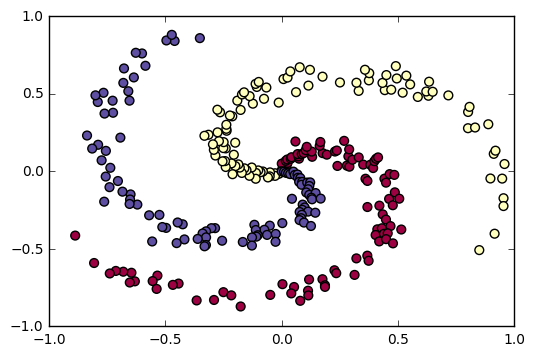

In [17]:
class ClusterData:
    """The clustering example data.

    Taken from http://nbviewer.jupyter.org/url/cs224d.stanford.edu/notebooks/vanishing_grad_example.ipynb

    """
    np.random.seed(0)
    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes

    n_train = N * K
    X = np.zeros((n_train, D))
    y = np.zeros([n_train], dtype=int)

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j * 4,(j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j

    # Generate a meshgrid that is used later for visualisation.
        
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.scatter(ClusterData.X[:, 0], ClusterData.X[:, 1], c=ClusterData.y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [18]:
class MLP2:
    def __init__(self, d_in=2, h1=50, h2=50, d_out=3):
        """Multi layer perceptron with two hidden layers.

        :param int D: the dimensionality of input.
        :param int h1: the dimensionality of the bottom hidden layer.
        :param int h2: the dimensionality of the top hidden layer.
        :param int d_out: the dimensionality of the output layer.

        """
        with tf.name_scope('input'):
            self.x = tf.placeholder(tf.float32, shape=[None, d_in], name='x-input')
            self.y = tf.placeholder(tf.int32, shape=None, name='y-input')

        with tf.name_scope('layer_1'):
            self.W_1 = tf.Variable(tf.random_normal(shape=[d_in, h1], seed=1), name='W_1')
            self.b_1 = tf.Variable(0.0, name='b_1')

            self.h_1 = tf.nn.relu(tf.matmul(self.x, self.W_1) + self.b_1, name='h_1')

        with tf.name_scope('layer_2'):
            self.W_2 = tf.Variable(tf.random_normal(shape=[h1, h2], seed=2), name='W_2')
            self.b_2 = tf.Variable(0.0, name='b_2')

            self.h_2 = tf.nn.relu(tf.matmul(self.h_1, self.W_2) + self.b_2, name='h_2')

        with tf.name_scope('output'):
            self.W_3 = tf.Variable(tf.random_normal(shape=[h2, d_out]), name='W_3')
            self.y_hat = tf.matmul(self.h_2, self.W_3, name='y_hat')

In [19]:
g = tf.Graph()
ts = timestamp()
min_loss = 0.013

mesh_predictions = []

# Explicitely tell what graph to use.
with g.as_default():
    mlp2 = MLP2(d_in=ClusterData.D, d_out=ClusterData.K)

    # Name scopes group logically relted variables.
    with tf.name_scope('cross_entropy'):
        # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py#L111
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(mlp2.y_hat, mlp2.y))

    with tf.name_scope('optimizer'):
        # https://github.com/dennybritz/cnn-text-classification-tf/blob/master/train.py#L89
        optimizer = tf.train.AdamOptimizer()
        # Compute gradients, so we can later summarise them.
        grads_and_vars = optimizer.compute_gradients(cross_entropy)
        
        # The optimiser can count the steps for us.
        global_step = tf.Variable(1, name='global_step', trainable=False)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

    init_op = tf.global_variables_initializer()

    # Prepare the summary ops for gradients. You should see the vanishing gradients problem.
    for grad, var in grads_and_vars:
        if grad is not None:
            tf.summary.histogram('{}/grad/hist'.format(var.name.replace(':', '_')), grad)
            tf.summary.scalar('{}/grad/magnitude-sum'.format(var.name.replace(':', '_')), tf.reduce_sum(tf.abs(grad)))

    tf.summary.scalar(cross_entropy.op.name, cross_entropy)
    summary_op = tf.summary.merge_all()

with tf.Session(graph=g) as sess, \
    closing(tf.summary.FileWriter('notebook_runs/clustering_train{}'.format(ts), sess.graph)) as train_summary_writer:

    sess.run(init_op)

    # We don't need to counts the steps anymore, the optimizer does it for us.
    while True:
        #
        # Training step
        #
        # Retrieve the current step, summaries and current_cross_entropy
        _, current_step, summary, current_cross_entropy = sess.run(
            [train_op, global_step, summary_op, cross_entropy],
            feed_dict={mlp2.x: ClusterData.X, mlp2.y: ClusterData.y},
        )
        train_summary_writer.add_summary(summary, current_step)

        if (current_step % 10000 == 0) or (current_cross_entropy < min_loss):
            print('Step: {}, cross_entropy: {:0.5f}'.format(current_step, current_cross_entropy))

        #
        # Every now and then make predictions for the visualisation below.
        #
        if (current_step % 100 == 0):
            mesh_predictions.append(
                (
                    np.argmax(
                        sess.run(
                            mlp2.y_hat, feed_dict={mlp2.x: np.c_[ClusterData.xx.ravel(), ClusterData.yy.ravel()]}
                        ),
                        axis=1)
                    .reshape(ClusterData.xx.shape),
                    current_step,
                )
            )
            
        if current_cross_entropy < min_loss:
            break

Step: 9334, cross_entropy: 0.01300


Go back to TensorBoard, the run data should appear there.

![Clustering scalars](scalars-clustering.png)

Notice operation grouping.

![Clustering graphs](graphs-clustering.png)

Visualise the predictions we've collected.

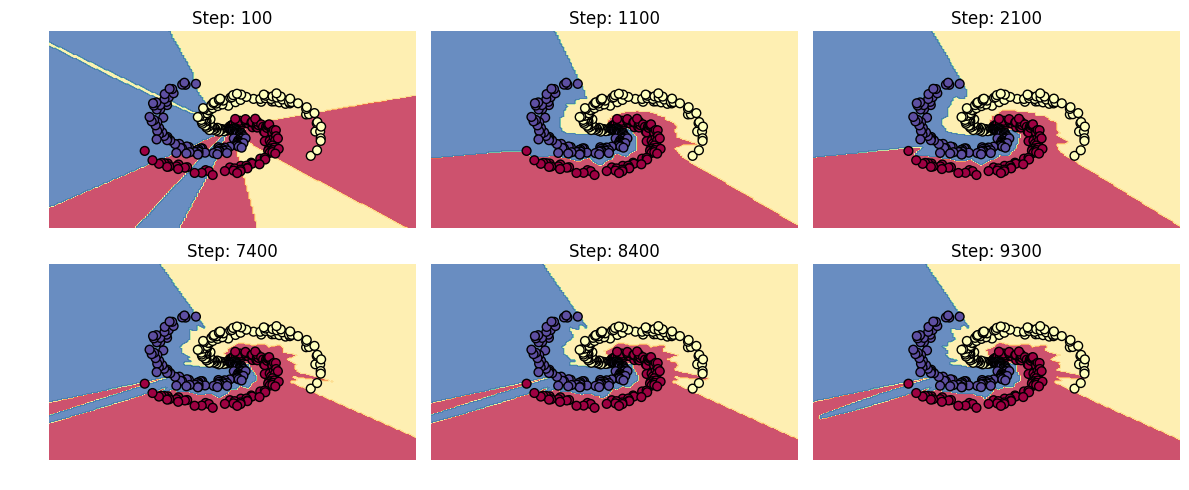

In [20]:
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 5))

for ax, Z_i in zip(chain.from_iterable(axs), [0, 10, 20, -20, -10, -1]):
    Z, step = mesh_predictions[Z_i]
    ax.contourf(ClusterData.xx, ClusterData.yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    ax.scatter(ClusterData.X[:, 0], ClusterData.X[:, 1], c=ClusterData.y, s=40, cmap=plt.cm.Spectral)
    ax.set_xlim(ClusterData.xx.min(), ClusterData.xx.max())
    ax.set_ylim(ClusterData.yy.min(), ClusterData.yy.max())
    ax.set_title('Step: {}'.format(step))
    ax.set_axis_off()

f.tight_layout()

In case you have all the tools intalled, you can generate a video.
```python
fig = plt.figure()

plt.xlim([-1,1])
plt.ylim([-1,1])

end = len(mesh_predictions) - 1
start = 20
frame_step = (end - start) // 30
frames = list(range(start, end, frame_step))

def animate(i):
    Z, current_step = mesh_predictions[frames[i]]
    cont = plt.contourf(ClusterData.xx, ClusterData.yy, Z, s=40, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(ClusterData.X[:, 0], ClusterData.X[:, 1], c=ClusterData.y, s=40, cmap=plt.cm.Spectral)
    plt.title('Step: {}'.format(current_step))
    return cont

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=60)
HTML(anim.to_html5_video())
```

# Queue

Queues is an alternative method to push data into the graph. When queues are used, there a part of the graph that pushes data into the queue using `feed_dict` and another part of the graph that performs training, but the inputs are pulled from the queue.

http://stackoverflow.com/questions/34594198/how-to-prefetch-data-using-a-custom-python-function-in-tensorflow

In [21]:
from contextlib import closing
from datetime import datetime
from itertools import count, chain
from threading import Thread

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [22]:
def timestamp():
    return datetime.now().isoformat()

In [23]:
g = tf.Graph()

with g.as_default():
    #
    # Push data into the queue.
    #
    enqueue_x = tf.placeholder('float', shape=None)
    enqueue_y = tf.placeholder('float', shape=None)

    q = tf.FIFOQueue(100, ['float', 'float'], shapes=[[], []])
    enqueue_op = q.enqueue_many([enqueue_x, enqueue_y])

    #
    # Pulling the data from the queue. x_batch and y_batch should be used as inputs fro training.
    #
    x_batch, y_batch = q.dequeue_up_to(2)

with tf.Session(graph=g) as sess:
    sess.run(enqueue_op, feed_dict={enqueue_x: [1.0, 2.5, 3.0], enqueue_y: [2.0, 3.0, 4.0]})
    x = sess.run(x_batch)
x

array([ 1. ,  2.5], dtype=float32)

The main benefit is that now data can be pushed in to a graph from another tread.

In [24]:
class linear_regression_from_queue:
    """Linear model that uses a queue for input."""
    def __init__(self, batch_size=2):
        with tf.name_scope('input_queue'):
            self.enqueue_X = tf.placeholder('float', shape=None, name='enq_X')
            self.enqueue_Y = tf.placeholder('float', shape=None, name='enq_Y')

            self.queue = tf.FIFOQueue(100, ['float', 'float'], shapes=[[], []])
            self.enqueue_op = self.queue.enqueue_many([self.enqueue_X, self.enqueue_Y])

        with tf.name_scope('input'):
            self.X, self.Y = self.queue.dequeue_up_to(batch_size)

        with tf.name_scope('parameters'):
            self.W = tf.Variable(1.0, name='weight')
            self.b = tf.Variable(0.0, name='bias')

        with tf.name_scope('prediction'):
            self.y_hat = self.X * self.W + self.b

        with tf.name_scope('cost'):
            self.cost = tf.reduce_mean(tf.pow(self.y_hat - self.Y, 2)) / 2

        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(self.cost)

In [25]:
def fetch_data(sess, regression, coord, n_samples=3):
    '''Fetch training data.'''
    
    while not coord.should_stop():
        X = np.random.normal(0, 1, n_samples)
        Y = 7 * X - 1 + np.random.normal(0, 0.2, n_samples)
        try:
            sess.run(
                regression.enqueue_op,
                feed_dict={
                    regression.enqueue_X: X,
                    regression.enqueue_Y: Y,
                }
            )
        except tf.errors.CancelledError as e:
            break

In [26]:
g = tf.Graph()
ts = timestamp()
coord = tf.train.Coordinator()

with g.as_default():
    regression = linear_regression_from_queue(batch_size=3)

    tf.summary.scalar('cost', regression.cost)

    init_op = tf.global_variables_initializer()
    summary_op = tf.summary.merge_all()

with tf.Session(graph=g) as sess, \
     closing(tf.summary.FileWriter('notebook_runs/linear_regression_train-{}'.format(ts), sess.graph)) as train_summary_writer:

    producer = Thread(target=fetch_data, args=(sess, regression, coord))
    producer.start()

    sess.run(init_op)
        
    for step in count(start=1):
        _, summary, train_cost = sess.run([regression.optimizer, summary_op, regression.cost])
        train_summary_writer.add_summary(summary, step)

        if train_cost < 0.0001:
            break

    sess.run(regression.queue.close(cancel_pending_enqueues=True))
            
    print(
        'W: {:.3f}, b: {:.3f}, cost: {:3f}, steps: {}'.format(*sess.run([regression.W, regression.b, regression.cost]), step)
    )
    
    coord.request_stop()
    regression.queue.close(cancel_pending_enqueues=True)
    coord.join([producer], stop_grace_period_secs=3)

W: 6.993, b: -1.062, cost: 0.026798, steps: 54
